<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/28)_%EB%AA%A8%EB%B0%94%EC%9D%BC_%EA%B2%8C%EC%9E%84_A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모바일 게임 A/B testing
>**목차**

* 문제상황 및 데이터 살펴보기   
* 문제해결 프로세스 정의  
1) A/B testing에 대한 정의  
2) 반응률 분석  
3) T-test 활용 A/B testing

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter26')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter26' ← 변경X
# os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🎮 (서비스 운영자, 마케터/개발자)

```
A게임사는 이번에 업데이트한 게임 Version에 대해서 적용 여부를 검토 중이다. 단순한 버그를 잡기위한 업데이트가 아닌 게임의 컨텐츠와 방식에  
대한 전반적인 내용이 변경되는 대대적인 업데이트라 반영하기 이전에 정말 효과가 있는지 검증해보고자 한다. 따라서 몇 명의 User에  
대해서 테스트해보고 효과가 있다면 Version up을 진행하고자 한다.

```  

> **데이터 살펴보기**

* 게임 version별 A/B test data
* 데이터 명세 ⬇

|user_id|version|sum_gamerounds|retention_1|retention_7|
|:---:|:---:|:---:|:---:|:---:|
|사용자 ID|버젼|총 플레이 횟수|1일 이후 재방문|7일 이후 재방문|


In [2]:
# Data read
import pandas as pd
bath = '/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter28_모바일 게임 A-B teting/'
df = pd.read_csv(bath + 'chapter28_game.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True



## **문제해결 프로세스 정의**
---
> **문제정의**

```
 Version 업데이트 적용여부 불분명
```  

> **기대효과**

```
Version 업데이트 확정 및 진행
```

> **해결방안**

```
A/B test를 통해 Version up 유의미성 확인 및 업데이트 수행
Session 1
 - Data 전처리 및 A/B Test에 대한 이해
Session 2
 - A/B test 사전 준비
 Session 3
 - A/B test (플레이 횟수, 설치 후 1일, 설치 후 7일)
```

> **성과측정**  

```
T test 결과, 유의미성 확인(P-value)
```

> **현업적용**  

```
T test 결과에 따라 업데이트 결정
```

> **주요 코드 미리 살펴보기**  

```
session 1 → groupby.agg()
session 2 → groupby.agg()
session 3 → stats.bartlett(), stats.ttest_ind(), stats.chi2_contingency()
```

## Session 1
## A/B testing 정의

### Data 전처리
---

In [3]:
# Data shape
# 90189 rows, 5 cols
print('df', df.shape)

df (90189, 5)


In [4]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
# null 확인
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [6]:
# outlier
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


<Axes: xlabel='sum_gamerounds', ylabel='Density'>

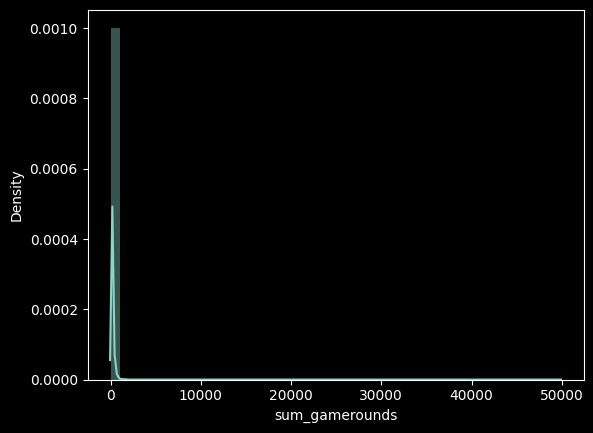

In [7]:
# sum_gamerounds 평균대비 max가 상식적으로 너무 커서 이해하기 어려움
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.distplot(df['sum_gamerounds'])

In [8]:
# 5,000회 이상인 Data 확인 1건
df[df['sum_gamerounds']>3000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [9]:
df = df[df['sum_gamerounds']<5000]
df.describe()

,userid,sum_gamerounds
count,9.018800e+04,90188.000000
mean,4.998397e+06,51.320253
std,2.883298e+06,102.682719
min,1.160000e+02,0.000000
25%,2.512211e+06,5.000000
50%,4.995804e+06,16.000000
75%,7.496461e+06,51.000000
max,9.999861e+06,2961.000000


### A/B test
---
* 웹페이지, 어플리케이션, 게임, 마케팅 등 서로 다른 2개의 상황에서의 반응률을 비교하여 어떤 상황이 더 효과적인지 판단하는 방법론  
* 일반적으로 A가 기존 상황, B가 새로 변경할 상황  
* 가설 수립-실험 진행 - 결과분석(3단계)
---
* A/B test 예시
 - 넷플리스 랜딩 페이지의 카피 문구
 - 상품의 가격이 100달러 미만일시, 할인가격이 아닌 할인율을 표현
 - 페이지 탐색시 무한 스크롤 VS 페이지 section

* 현업 활용 A/B 예시
 - 타겟 마케팅 수행 후 실험군/대조군 반응률 GAP 분석
 - 마케팅 채널에 따른 반응률 GAP 분석



### · A/B Test Process
---
> **1단계**

```
 Test 설계 : 비교하고자 하는 A/B를 정의
```  

> **2단계**

```
가설 수립 (ex. A와 B의 반응률은 차이가 없을 것이다.)
```

> **3단계**

```
Pilot test를 통한 데이터 수집
```

> **4단계**  

```
T test 및 결과 확인
```

> **5단계**  

```
유의하다면 B를 적용
```

## Session 2
## 반응률 분석

### 데이터 EDA
---

In [10]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [11]:
# 총 user 수
# 90,188
df['userid'].count()

90188

In [12]:
# version별 User id
print('gate_30 :', len(df[df['version']=='gate_30']))
print('gate_40 :', len(df[df['version']=='gate_40']))

gate_30 : 44699
gate_40 : 45489


In [13]:
import numpy as np
df['retention_1'] = np.where(df['retention_1']==True,1,0)
df['retention_7'] = np.where(df['retention_7']==True,1,0)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


### sum_gamerounds 분포 비교
---

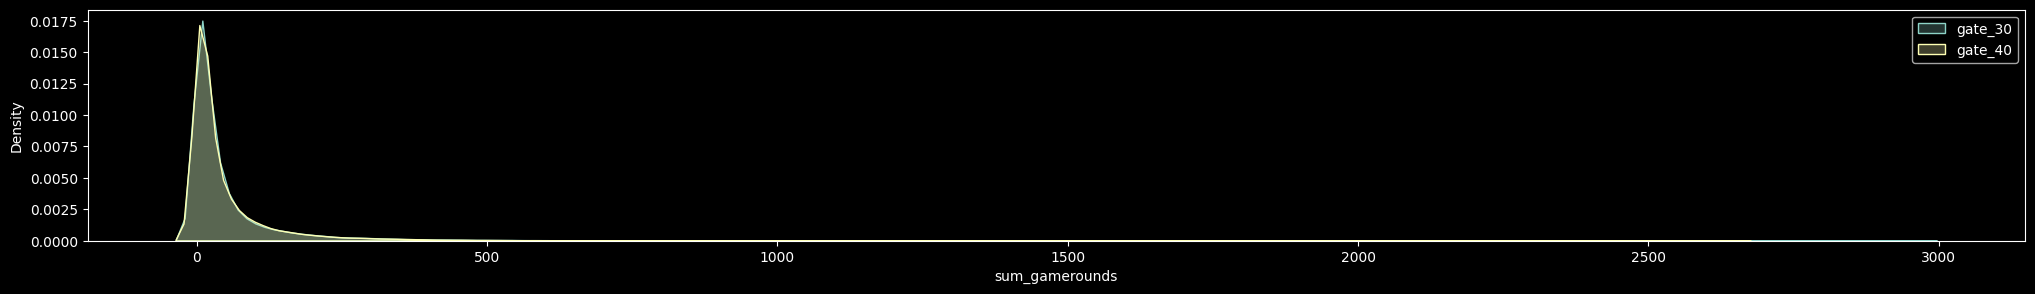

In [14]:
# sum_gamerounds 연속형 변수 version별 분포 비교
sns.kdeplot(df[df['version']=='gate_30']['sum_gamerounds'], shade=True, label='gate_30')
sns.kdeplot(df[df['version']=='gate_40']['sum_gamerounds'], shade=True, label='gate_40')
plt.gcf().set_size_inches(25,3)
plt.legend()
plt.show()

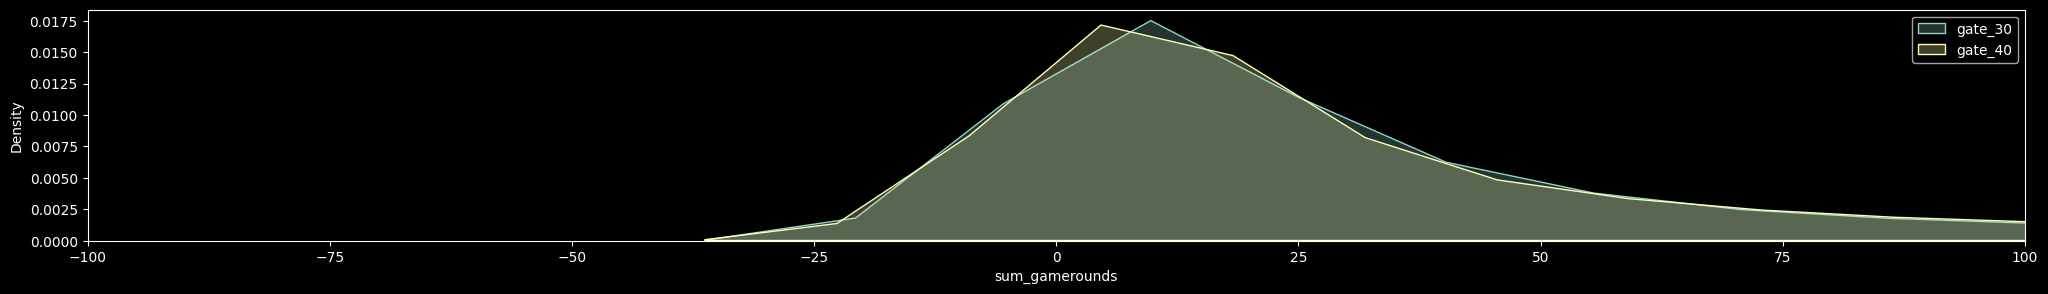

In [15]:
# sum_gamerounds, 연속형 변수의 version별 분포 비교, xlim 조절
# 그래프 상으로는 크게 차이가 있는지 확인 불가
sns.kdeplot(df[df['version']=='gate_30']['sum_gamerounds'], shade=True, label='gate_30')
sns.kdeplot(df[df['version']=='gate_40']['sum_gamerounds'], shade=True, label='gate_40')
plt.gcf().set_size_inches(25,3)
plt.legend()
plt.xlim(-100,100)
plt.show()

In [16]:
# version별 게임횟수 평균 비교
df[df['version']=='gate_30']['sum_gamerounds'].mean(), df[df['version']=='gate_40']['sum_gamerounds'].mean()

(51.342110561757536, 51.29877552814966)

In [17]:
# version별 retension 평균 비교
# 약 19%
df[df['version']=='gate_30']['retention_7'].value_counts()

retention_7
0    36198
1     8501
Name: count, dtype: int64

In [18]:
8501/(36198+8501)
8279/(37210+8279)

0.18200004396667327

In [19]:
# version별 retension 평균 비교
# 약 18%
df[df['version']=='gate_40']['retention_7'].value_counts()

retention_7
0    37210
1     8279
Name: count, dtype: int64

### A/B test를 위한 사전 데이터 준비
---

In [20]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [21]:
# 연속형 변수는 평균, 범주형 변수는 반응률
df.groupby('version')[['sum_gamerounds', 'retention_1','retention_7']].agg(['mean','count','sum'])

sum_gamerounds                 retention_1               retention_7  \
                  mean  count      sum        mean  count    sum        mean   
version                                                                        
gate_30      51.342111  44699  2294941    0.448198  44699  20034    0.190183   
gate_40      51.298776  45489  2333530    0.442283  45489  20119    0.182000   

                      
         count   sum  
version               
gate_30  44699  8501  
gate_40  45489  8279

In [22]:
# 연속형 변수는 평균, 범주형 변수는 반응률, reset_index로 multi index를 제거
df_pivot = pd.DataFrame(df.groupby('version')[['sum_gamerounds', 'retention_1','retention_7']].agg(['mean','count','sum']).reset_index())
df_pivot

version sum_gamerounds                 retention_1                \
                     mean  count      sum        mean  count    sum   
0  gate_30      51.342111  44699  2294941    0.448198  44699  20034   
1  gate_40      51.298776  45489  2333530    0.442283  45489  20119   

  retention_7               
         mean  count   sum  
0    0.190183  44699  8501  
1    0.182000  45489  8279

In [23]:
# col 재정비(1)
df_pivot.columns = ['version','sum_gamerounds_mean','sum_gamerounds_count','sum_gamerounds_sum','retention_1_mean','retention_1_count','retention_1_sum','retention_7_mean','retention_7_count','retention_7_sum']
df_pivot

,version,sum_gamerounds_mean,sum_gamerounds_count,sum_gamerounds_sum,retention_1_mean,retention_1_count,retention_1_sum,retention_7_mean,retention_7_count,retention_7_sum
0,gate_30,51.342111,44699,2294941,0.448198,44699,20034,0.190183,44699,8501
1,gate_40,51.298776,45489,2333530,0.442283,45489,20119,0.182000,45489,8279


In [24]:
# col 재정비(2)
df_pivot = df_pivot[['version','sum_gamerounds_mean','retention_1_count','retention_1_sum','retention_7_count','retention_7_sum']]
df_pivot

,version,sum_gamerounds_mean,retention_1_count,retention_1_sum,retention_7_count,retention_7_sum
0,gate_30,51.342111,44699,20034,44699,8501
1,gate_40,51.298776,45489,20119,45489,8279


In [25]:
# 반응률 계산
df_pivot['retention_1_ratio'] = df_pivot['retention_1_sum']/df_pivot['retention_1_count']
df_pivot['retention_7_ratio'] = df_pivot['retention_7_sum']/df_pivot['retention_7_count']
df_pivot

,version,sum_gamerounds_mean,retention_1_count,retention_1_sum,retention_7_count,retention_7_sum,retention_1_ratio,retention_7_ratio
0,gate_30,51.342111,44699,20034,44699,8501,0.448198,0.190183
1,gate_40,51.298776,45489,20119,45489,8279,0.442283,0.182000


In [26]:
df_pivot.columns

Index(['version', 'sum_gamerounds_mean', 'retention_1_count',
       'retention_1_sum', 'retention_7_count', 'retention_7_sum',
       'retention_1_ratio', 'retention_7_ratio'],
      dtype='object')

In [27]:
df_pivot[['version', 'sum_gamerounds_mean', 'retention_1_ratio', 'retention_7_ratio']]

,version,sum_gamerounds_mean,retention_1_ratio,retention_7_ratio
0,gate_30,51.342111,0.448198,0.190183
1,gate_40,51.298776,0.442283,0.182000


In [28]:
# diff 계산
print('sum_gamerounds_diff :', df_pivot['sum_gamerounds_mean'].iloc[0] - df_pivot['sum_gamerounds_mean'].iloc[1])
print('retention_1_diff :', df_pivot['retention_1_ratio'].iloc[0] - df_pivot['retention_1_ratio'].iloc[1])
print('retention_7_diff :', df_pivot['retention_7_ratio'].iloc[0] - df_pivot['retention_7_ratio'].iloc[1])

sum_gamerounds_diff : 0.04333503360787461
retention_1_diff : 0.005915196587034155
retention_7_diff : 0.00818318160884296


## Session 3
## T-test 활용 A/B testing

### sum play game rounds T-test
---

In [29]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [30]:
# 등분산성 만족 X, 두 데이터에 분산이 동일하지 않다.
# [귀무가설],H0 = A, B는 분산이 동일하다. if P-value < 0.05 (기각)
# [대립가설],H1 = A, B는 분산이 동일하지 않다. (채택)

from scipy import stats
tstat, pvalue = stats.bartlett(df[df['version']=='gate_30']['sum_gamerounds'], df[df['version']=='gate_40']['sum_gamerounds'])
print('P-value:', round(pvalue,3))

P-value: 0.011


In [31]:
# P-value가 0.05이하면, 귀무가설을 기각할 수 있다.
# 귀무가설(H0) : gate30 과 gate40의 게임횟수 평균이 같다.  if P-value > 0.05 (채택)
# 대립가설(H1) : gate30 과 gate40의 게임횟수 평균이 다르다.
tstat, pvalue = stats.ttest_ind(df[df.version == 'gate_30'].sum_gamerounds, df[df.version == 'gate_40'].sum_gamerounds, equal_var=False)
print("P-value:", round(pvalue,3))

P-value: 0.949


### Retention_1 chi2 test
---
* 범주형, 명목형 변수의 자료 분석에 사용  
* 관찰 빈도와 기대빈도에 대해서 비교

In [32]:
df_pivot

,version,sum_gamerounds_mean,retention_1_count,retention_1_sum,retention_7_count,retention_7_sum,retention_1_ratio,retention_7_ratio
0,gate_30,51.342111,44699,20034,44699,8501,0.448198,0.190183
1,gate_40,51.298776,45489,20119,45489,8279,0.442283,0.182000


In [33]:
# 필요한 Data만 추출
df_pivot_1 = df_pivot[['version', 'retention_1_count', 'retention_1_sum']]
df_pivot_1

,version,retention_1_count,retention_1_sum
0,gate_30,44699,20034
1,gate_40,45489,20119


In [34]:
# 반응한 고객과 반응하지 않은 고객에 대한 관찰 빈도 필요
df_pivot_1['retention_1_no'] = df_pivot_1['retention_1_count']-df_pivot_1['retention_1_sum']
df_pivot_1 = df_pivot_1[['retention_1_sum', 'retention_1_no']]
df_pivot_1.columns = ['yes', 'no']
df_pivot_1

,yes,no
0,20034,24665
1,20119,25370


In [36]:
#  H0 : A와 B의 리텐션 반응률 차이가 없다. if p-value < 0.05 미만 (x, 기각 X)
#  H1 : A와 B의 리텐션 반응률 차이가 있다.
chi2, p_value, df, _ = stats.chi2_contingency(df_pivot_1)
print('P-value:', p_value)

P-value: 0.07500999897705693


### Retention_7 chi2 test
---

In [37]:
df_pivot

,version,sum_gamerounds_mean,retention_1_count,retention_1_sum,retention_7_count,retention_7_sum,retention_1_ratio,retention_7_ratio
0,gate_30,51.342111,44699,20034,44699,8501,0.448198,0.190183
1,gate_40,51.298776,45489,20119,45489,8279,0.442283,0.182000


In [38]:
# 필요한 Data만 추출
df_pivot_2 = df_pivot[['version', 'retention_7_count', 'retention_7_sum']]
df_pivot_2

,version,retention_7_count,retention_7_sum
0,gate_30,44699,8501
1,gate_40,45489,8279


In [39]:
#  반응한 고객과 반응하지 않은 고객에 대한 관찰 빈도가 필요함
df_pivot_2['retention_7_no'] = df_pivot_2['retention_7_count'] - df_pivot_2['retention_7_sum']
df_pivot_2 = df_pivot_2[['retention_7_sum', 'retention_7_no']]
df_pivot_2.columns = ['yes', 'no']
df_pivot_2

,yes,no
0,8501,36198
1,8279,37210


In [40]:
# H0 : A와 B의 리텐션 반응률 차이가 없다. if p-value < 0.05 미만 (O, 기각 O)
# H1 : A와 B의 리텐션 반응률 차이가 있다.(채택)
chi2, p_value, df, _ = stats.chi2_contingency(df_pivot_2)
print("P-value:",p_value)

P-value: 0.0016391259678654423


### 결론
---

In [41]:
# diff 계산 Gate30 - Gate40
print('sum_gamerounds_diff :',df_pivot['sum_gamerounds_mean'].iloc[0] - df_pivot['sum_gamerounds_mean'].iloc[1])
print('retention_1_diff :', df_pivot['retention_1_ratio'].iloc[0] - df_pivot['retention_1_ratio'].iloc[1])
print('retention_7_diff :', df_pivot['retention_7_ratio'].iloc[0] - df_pivot['retention_7_ratio'].iloc[1])

sum_gamerounds_diff : 0.04333503360787461
retention_1_diff : 0.005915196587034155
retention_7_diff : 0.00818318160884296


* Gate30이 Gate40 대비 +0.04 더 많은 게임플레이횟수를 보였으나 우연에의해 차이가 발생했을 확률이 높다
* Gate30이 Gate40 대비 +0.005%p 더 많은 설치 후 1일 이내 리텐션율을 보였고, 유의성이 없다
* Gate30이 Gate40 대비 +0.008%p 더 많은 설치 후 7일 이내 리텐션율을 보였고, 신뢰수준 99% 이상으로 유의성이 있다.
